# The A* algorithm
The objective for this homework is to explore the A* algorithm for both open space type maps and maze like maps. In the process of this exploration, I created methods to load/generate maps, convert those maps into a graph, and explore that graph using A*. I also tried implementing and profiling different heuristic methods in order to identify the impact of the heuristic function on the efficiency of the search.

# Generating and loading maps as images
Our first task is to create methods that generate images having random obstacles in them. We also want to be able to read images collected from some other source, specifically images of mazes.

In [1]:
"""
Created on Thu Jan 27 22:22:03 2022

@author: jonathan
"""
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import heapq
import cv2
import time

## Generating open space type maps
The following section defines functions to generate a map with random obstacles within a region and discretize that map into an image. The culmination of this section is the `create_map()` function which takes the number of obstacles, the type of the obstacles (polygons or circles) and the desired dimension of the returned image in pixels. This function returns an image, a starting point, and a goal point such that the start and goal points don't lie within an obstacle

### Making a random polygon
To make a random polygon, we generate and sort a set of `n` random angles around a circle. We then generate a radius for that angle that is uniformly distributed about some target radius. Finally we connect all these points to create a polygon. Our obstacle is stored as a matplotlib `patch` object which has features we can leverage later.

(0.0, 4.0)

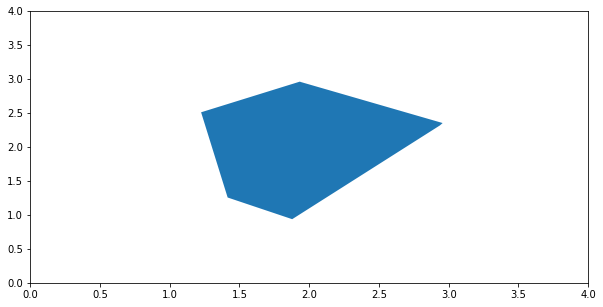

In [2]:
def make_poly(x, y, r, n):
    """Make a convex polygon centered at (x,y) """
    ts = np.sort(np.random.uniform(0, 2*np.pi, n))
    rs = np.random.uniform(r*0.9, r*1.1, n)

    pts = np.array([rs*np.cos(ts) + x, rs*np.sin(ts) + y]).T

    poly = plt.Polygon(pts)
    return poly

poly = make_poly(2,2,1,7)
fig, ax = plt.subplots(1,1)
ax.add_patch(poly)
ax.set_xlim(0,4)
ax.set_ylim(0,4)

### Generating a map of random obstacles

Generating random obstacles is done as follows. First we generate a random center point within our chosen domain of (-5,5) in both x and y. We also randomly generate a radius for the obstacle. We then use the matplotlib `contains_point()` function to check whether the starting point or goal point is contained within the obstacle patch and generate a new obstacle until both the starting point and goal point are in free space. This process is repeated until the desired number of obstacles has been successfully created.

Text(0.5, 1.0, 'A set of 10 randomly generated polygons')

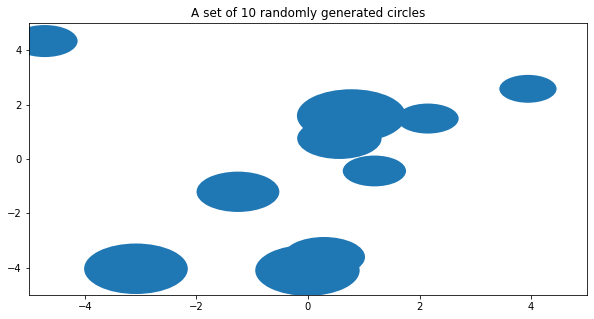

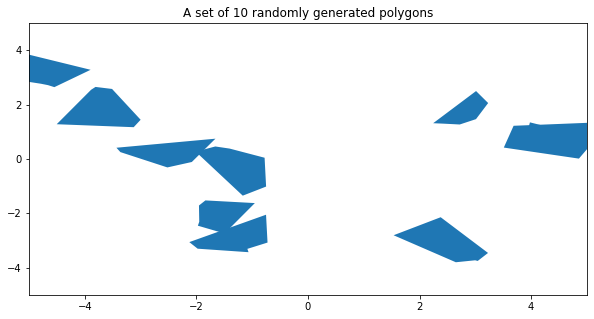

In [3]:
def generate_random_obstacles(n, obs_type, start_pt, goal_pt):
    sigma = 2
    obstacles = []
    for i in range(n):
        x = np.random.uniform(-5,5)
        y = np.random.uniform(-5,5)
        r = np.random.uniform(0.5, 1)
        if obs_type == "circles":
            patch = plt.Circle([x, y], r)
        elif obs_type == "polygons":
            patch = make_poly(x, y, r, 6)
        else:
            raise RuntimeError("Valid obstacle types are 'circles' or 'polygons'")
        while patch.contains_point(start_pt) or patch.contains_point(goal_pt):
            x = np.random.uniform(-5,5)
            y = np.random.uniform(-5,5)
            r = np.random.uniform(0.5, 1)
            if obs_type == "circles":
                patch = plt.Circle([x, y], r)
            elif obs_type == "polygons":
                patch = make_poly(x, y, r, 6)
        obstacles.append(patch)
    return obstacles

start_pt = [-3,-3]
goal_pt = [3,3]
circle_obs = generate_random_obstacles(10, "circles", start_pt, goal_pt)
fig, ax = plt.subplots()
for patch in circle_obs:
    ax.add_patch(patch)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.title("A set of 10 randomly generated circles")

poly_obs = generate_random_obstacles(10, "polygons", start_pt, goal_pt)
fig, ax = plt.subplots()
for patch in poly_obs:
    ax.add_patch(patch)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.title("A set of 10 randomly generated polygons")

### Converting obstacles to an image

To convert the generated obstacles into an image, we first generate an image that's all white. We then iterate through the set of obstacles. For each obstacle, we get the bounding box using the matplotlib `get_window_extent()` function. We then iterate through the pixels contained within the bounding box for our patch and swap any pixels whose center is contained within the obstacle from white to black.

I did run into one edge case in which the starting point or goal point are very close to the edge of the obstacle. In this case, it is possible for the point to be outside the polygon, but inside the polygon after discretization. In order to fix this, I force the starting point pixel and goal point pixels to be white regardless of what happened during discretization. I also convert the starting point and goal point to the pixel space coordinates and return them at the end.

Text(0.5, 1.0, '10 random polygons converted to an image')

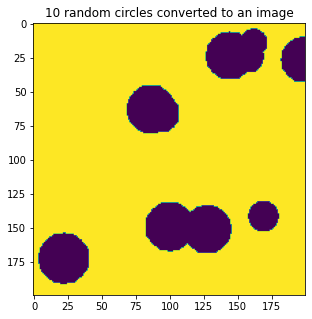

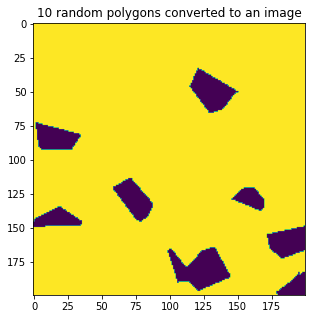

In [4]:
def convert_obstacles_to_image(obstacles, img_shape, start_pt, goal_pt):
    img = np.ones(img_shape)
    xmin = -5
    xmax = 5
    xs = np.linspace(xmin, xmax, img_shape[1])
    ymin = xmin*img_shape[0]/img_shape[1]
    ymax = xmax*img_shape[0]/img_shape[1]
    ys = np.linspace(ymin, ymax, img_shape[0])

    for obs in obstacles:
        extent = obs.get_window_extent()
        imin = int((min(max(xmin, extent.x0), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        imax = int((min(max(xmin, extent.x1), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        jmin = int((min(max(ymin, extent.y0), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        jmax = int((min(max(ymin, extent.y1), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        for i in range(imin, imax):
            for j in range(jmin, jmax):
                if obs.contains_point([xs[i], ys[j]]):
                    img[j, i] = 0
    A = np.array([[img_shape[1]/(xmax-xmin), 0],
                  [0, img_shape[0]/(ymax-ymin)]])
    xscale = img_shape[1]/(xmax-xmin)
    yscale = img_shape[0]/(ymax-ymin)
    new_start = np.array(
        [(start_pt[0]-xmin)*xscale, (start_pt[1]-ymin)*yscale], dtype='int')
    img[new_start[1],new_start[0]] = 1
    new_goal = np.array(
        [(goal_pt[0]-xmin)*xscale, (goal_pt[1]-ymin)*yscale], dtype='int')
    img[new_goal[1], new_goal[0]] = 1
    return img, new_start, new_goal

circle_obs = generate_random_obstacles(10, "circles", start_pt, goal_pt)
img, img_start, img_goal = convert_obstacles_to_image(circle_obs, (200,200), start_pt, goal_pt)
plt.figure()
plt.imshow(img)
plt.title("10 random circles converted to an image")

poly_obs = generate_random_obstacles(10, "polygons", start_pt, goal_pt)
img, img_start, img_goal = convert_obstacles_to_image(poly_obs, (200,200), start_pt, goal_pt)
plt.figure()
plt.imshow(img)
plt.title("10 random polygons converted to an image")

### A function to create maps

Now that we have the prerequisite tools, we can wrap them in a nice function that randomly picks a starting point in the left half of the map and a goal point in the right half of the map and randomly places obstacles throughout the map. The map, of course, has been discretized into an image.

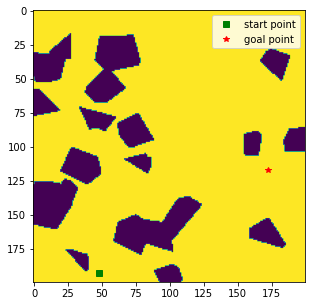

In [5]:
def create_map(num_obstacles, obstacle_type, map_size):
    start_pt = np.array([-3, 3])
    goal_pt = np.array([3, -3])
    start_pt = np.random.uniform([-5, -5], [0, 5], 2)
    goal_pt = np.random.uniform([0, -5], [5, 5], 2)
    obstacles = generate_random_obstacles(
        num_obstacles, obstacle_type, start_pt, goal_pt)
    img, img_start_pt, img_goal_pt = convert_obstacles_to_image(
        obstacles, (map_size, map_size), start_pt, goal_pt)
    return img, img_start_pt, img_goal_pt

img, img_start_pt, img_goal_pt = create_map(20, "polygons", 200)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs', label='start point')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*', label='goal point')
plt.legend()

## Loading a map from an image file

I used an [online maze generator tool](www.mazegenerator.net) to generate mazes as an image. The `load_map()` function is designed specifically to load images from this site with a known number of cells and to correctly down-sample them so that the structure of the maze is preserved, but the image is not excessively large. This process involves converting the image to grayscale, eroding the white areas of the map to make the walls and open spaces equivalent widths, resizing the image, and picking a random start and end point within free space in the map. After this loading process, the corridors and walls are all 2 pixels wide.

Text(0.5, 1.0, 'A 40x40 cell maze')

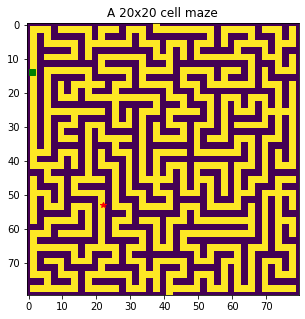

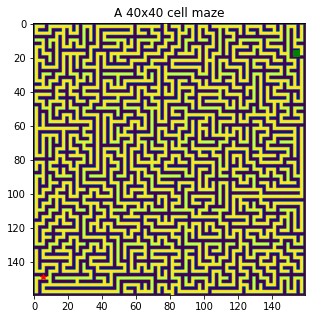

In [6]:
"""
mazes generated with https://www.mazegenerator.net/
"""


def load_map(filename, cells):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY)/255.0
    img = img[1:-1, 1:-1]
    img = cv2.erode(img, kernel=np.ones(
        (3, 3), dtype=np.float64), iterations=3)
    img = cv2.resize(img, (cells*4, cells*4))
    img_start_pt = np.random.randint([0, 0], [img.shape[1], img.shape[0]], 2)
    while(img[img_start_pt[1], img_start_pt[0]] < 0.5):
        img_start_pt = np.random.randint(
            [0, 0], [img.shape[1], img.shape[0]], 2)
    img_goal_pt = np.random.randint([0, 0], [img.shape[1], img.shape[0]], 2)
    while (img[img_goal_pt[1], img_goal_pt[0]] < 0.5):
        img_goal_pt = np.random.randint(
            [0, 0], [img.shape[1], img.shape[0]], 2)

    return img, img_start_pt, img_goal_pt

img, img_start_pt, img_goal_pt = load_map("20x20_orthogonal_maze.png", 20)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*')
plt.title("A 20x20 cell maze")

img, img_start_pt, img_goal_pt = load_map("40x40_orthogonal_maze.png", 40)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*')
plt.title("A 40x40 cell maze")

# Converting images into graphs

Once we have an image, we need a data structure to represent the graph and a mechanism to convert to this structure. Our graph is simply a class that holds a dictionary with all the nodes. They can be looked up with an `(x,y)` tuple. The nodes themselves contain
- a dictionary of neighbors,
- an element to store the shortest distance from the node back to the start, `g`, and 
- a reference to a function that will return a heuristic distance to the goal. 

We also overload the less than and equal operators for the Node class so that the nodes can be easily sorted within a heap data structure for fast access. The less than operator is overloaded in such a way that if two nodes are compared, the node with the smaller `f = g + h` value will be considered less than the other node. In this way, the heap will be automatically sorted according to `f`.

Converting the image to a graph is as simple then as iterating through the pixels of the image, creating a Node to represent each pixel in free space, filling that node's adjacency list by checking each possible neighbor,  and adding that node to the graph dictionary.

In [7]:
class Node():
    def __init__(self, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(np.array([self.x, self.y]))
        f2 = other.g+self.hfunc(np.array([other.x, other.y]))
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self):
        self.nodes = {}
    pass

pairs = [[-1, -1], [0, -1], [1, -1], [-1, 0], [1, 0], [-1, 1], [0, 1], [1, 1]]
pairs = [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]


def convert_img_to_graph(img, h):
    graph = Graph()
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            node = Node(h)
            node.x = i
            node.y = j
            for pair in pairs:
                a = i+pair[0]
                b = j+pair[1]
                if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0] and img[b, a]*img[j, i] == 1:
                    node.neighbors[pair] = np.linalg.norm(pair)
                else:
                    pass
            graph.nodes[(i, j)] = node
    return graph

# Performing the A* search

We initialize our heap of nodes to search with the starting node. We then iterate, always taking the top item from the heap and examining its neighbors. We first check whether we have found a shorter path to the neighber than was thus far known. If so, we update the neighbor's `g` value. If the neighbor is also not in our heap, we add it to the heap because its state has changed and it may need to be reevaluated as an option for a path. The loop continues until we either have found a path to the goal or have exhausted all possibilities.

Once a path has been found, we retrace our steps to create a list of points along the path. The graph, discovered path, list of points searched, and path length are then returned.

In [8]:
def a_star(graph, start, goal, max_iter = np.Inf):
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append([curr_node.x, curr_node.y])
        for pair in curr_node.neighbors:
            a = curr_node.x + pair[0]
            b = curr_node.y + pair[1]
            weight = curr_node.neighbors[pair]
            try:
                other_node = graph.nodes[a, b]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [[curr_node.x, curr_node.y]]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, [curr_node.prev.x, curr_node.prev.y])
        path_length += np.linalg.norm([curr_node.x -
                                      curr_node.prev.x, curr_node.y-curr_node.prev.y])
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), path_length

## Define a heuristic

We also need to define a heuristic function. To begin with, we will simply use the L2 norm. Later we can experiment with alternate heuristics.

In [9]:
def h_l2_dist(node):
    return np.linalg.norm(node-img_goal_pt)

## Perform A* on a random map and plot

Now we have everything to perform A* on a randomly generated map and plot the results. We use `imshow()` to show the image and then overlay on that the following:

- a green square for the start
- a red star for the goal
- an x for every point that was searched
- a line showing the discovered path

In the title for the figure, we include a summary of the heuristic used, the total length of the discovered path, the number of points searched, and the time needed to compute the solution.

L2 Norm 0.26655149459838867


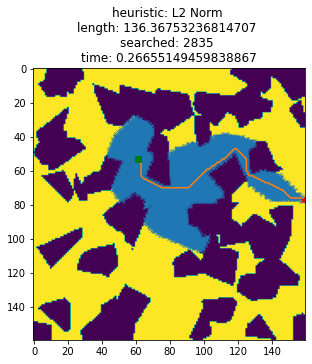

In [10]:
def perform_and_plot_a_star(img, h, h_name, max_iter = np.Inf):
    img_cp = img.copy()
    graph = convert_img_to_graph(img_cp, h)
    start = time.time()

    new_graph, path, searched, path_length = a_star(
        graph, img_start_pt, img_goal_pt, max_iter)
    end = time.time()

    print(h_name, end-start)
    fig, ax = plt.subplots()

    im = ax.imshow(img_cp)
    ax.set_title("heuristic: {} \nlength: {} \nsearched: {} \ntime: {}".format(h_name, path_length, len(searched), end-start))
    ax.plot(searched[:, 0], searched[:, 1], 'x')
    ax.plot(path[:, 0], path[:, 1])
    ax.plot(img_start_pt[0], img_start_pt[1], 'gs')
    ax.plot(img_goal_pt[0], img_goal_pt[1], 'r*')
    
img, img_start_pt, img_goal_pt = create_map(60, 'polygons', 160)
perform_and_plot_a_star(img, h_l2_dist, "L2 Norm")

## Perform A* on maze type map and plot

We can also load a maze type map and use A* to find the path as follows.

L2 Norm 0.3136582374572754


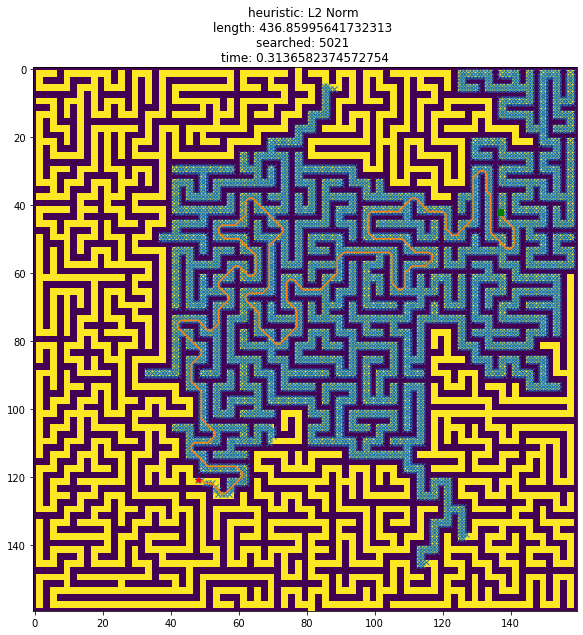

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]
img, img_start_pt, img_goal_pt = load_map("40x40_orthogonal_maze.png", 40)
perform_and_plot_a_star(img, h_l2_dist, "L2 Norm")
plt.rcParams['figure.figsize'] = [10, 5]


# Experiment with different heuristic functions

When I was experimenting with A*, I plotted an animation of the search strategy and was surprised to find out that using the L2 Norm causes what appears to be a non-optimal search. To begin with, the algorithm searches along a straight line towards the goal, but if an obstacle is encountered, it begins searching a pair of straight lines adjacent to the first one starting back at the start node and continuously widening the search. This seemed non-optimal to me because I know that any point along the adjacent line could be reached by simply branching off the first line at a later point rather than at the start. When we hit an obstacle, we should be able to backup from the obstacle with a cone-type search because we know that the distance will be as good as branching off back at the start node.

I did a lot of experimentation with different heuristic functions that estimated the distance from the goal as a hyperbola instead of a circle. I also tried a heuristic function that computes the minimum possible distance constrained by the directions you can move along the grid. This is similar to the manhattan distance, except that it takes into account diagonal movement as well. What I discovered was that the hyperbolic heuristic functions typically find the goal with fewer nodes searched but they are not guaranteed to find the shortest path. Using the squared distance as a heuristic also doesn't find the shortest path but the execution time is significantly less than the distance involving the square root.

I also measured the time to run a search with each of the heuristic functions and found that the hyperbolic heuristic functions don't actually perform much better on a full graph. They search fewer nodes, but this is offset by the increased computational complexity of evaluating the heuristic function. I was surprised by this result, so I actually profiled a run to see where the time was going. After profiling, it was clear that evaluating the heuristic function is by far the most costly part of the algorithm because it is performed so many times. Because of this, a lightweight heuristic function such as the grid-constrained distance can outperform the hyperbolic functions and also guarantee the shortest path.

The results also depended significantly on the map being explored. For some maps, the hyperbolic heuristics performed an order of magnitude better. For others, an order of magnitude worse. Since they don't guarantee the shortest path, I'm content to stick to the grid constrained distance as my preferred heuristic. The following section plots the results of all the heuristics on the same input map.

In [12]:

def h_sq_dist(node):
    return (node[0] - img_goal_pt[0])**2 + (node[1]-img_goal_pt[1])**2

s2 = np.sqrt(2)
def grid_dist(p1, p2):
    dx = np.abs(p1[0]-p2[0])
    dy = np.abs(p1[1]-p2[1])
    if dx > dy:
        return (dx-dy)+s2*dy
    else:
        return (dy-dx)+s2*dx


def h_grid_dist(node):
    return grid_dist(node, img_goal_pt)


def h_hyperbolic_1(node):
    return grid_dist(node, img_goal_pt)-grid_dist(node, img_start_pt)


def h_hyperbolic_2(node):

    fake_pt = img_start_pt - (img_goal_pt - img_start_pt)
    return grid_dist(node, img_goal_pt) - grid_dist(node, fake_pt)


def h_hyperbolic_3(node):

    fake_pt = img_start_pt - 2*(img_goal_pt - img_start_pt)
    return grid_dist(node, img_goal_pt) - grid_dist(node, fake_pt)


def h_parallel_goal_dist(node):
    dir_vec = img_goal_pt-img_start_pt
    unit_vec = dir_vec/np.linalg.norm(dir_vec)

    pos_vec = img_goal_pt-node
    return np.dot(pos_vec, unit_vec)

img_start_pt [147 193]
img_goal_pt [299 177]
circle 0.40375661849975586
grid circle 0.8803496360778809
squared dist 0.036712646484375
hyperbolic 1 0.19766616821289062
hyperbolic 2 0.19414663314819336
hyperbolic 3 0.2122328281402588


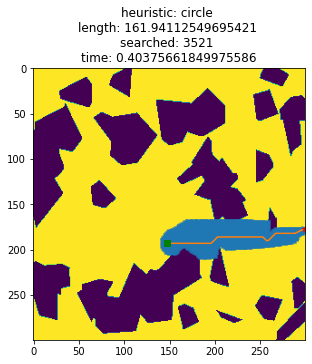

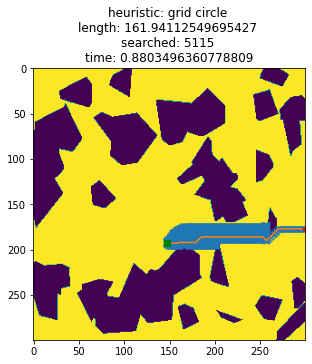

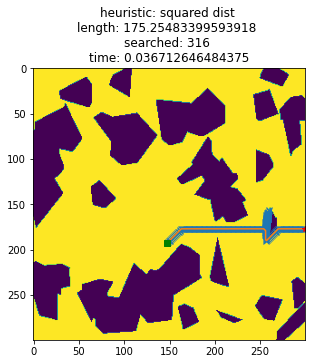

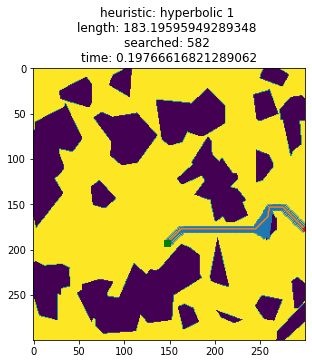

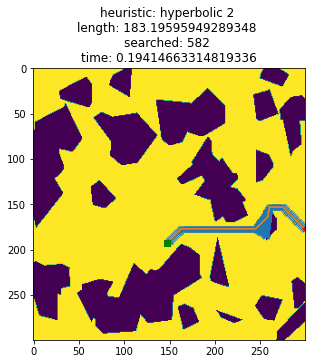

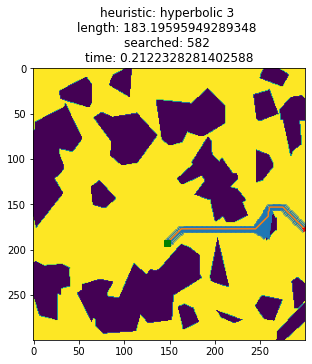

In [13]:
img, img_start_pt, img_goal_pt = create_map(40, 'polygons', 300)
#img, img_start_pt, img_goal_pt = load_map("20x20_orthogonal_maze.png", 20)
print("img_start_pt", img_start_pt)
print("img_goal_pt", img_goal_pt)

hs = [h_l2_dist, h_grid_dist, h_sq_dist,
      h_hyperbolic_1, h_hyperbolic_2, h_hyperbolic_3]
hnames = ['circle', 'grid circle', 'squared dist', 'hyperbolic 1',
          'hyperbolic 2', 'hyperbolic 3']
for h, name, hnum in zip(hs, hnames, range(len(hs))):
    perform_and_plot_a_star(img,h,name)

# Experiment with modified A*

I also tried modifying the A* algorithm to do more of a depth-first search. This approach more quickly found a path to goal, but the paths were significantly longer than those of regular A* . I have not included the code because I broke it trying to make it better and then abandoned the effort since it had no real advantage over classical A* and wasn't required for the assignment.

# Conclusion

The A* algorithm is an efficient means of finding the shortest path from one node to another in a graph. We were able to demonstrate its utility on both maps of random obstacles and on maze type maps. The performance can be improved to some extent by modifying the heuristic function, but at the cost of less optimal paths. For certain types of maps such as grid-based maps, the heuristic can be modified to be less costly while still guaranteeing that the shortest path is discovered.